<a href="https://colab.research.google.com/github/yuuiwqy622/isic2018melanoma-segmentation/blob/main/unet_melanoma_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount OneDrive

In [1]:
!wget https://downloads.rclone.org/v1.54.1/rclone-v1.54.1-linux-amd64.deb
!apt install ./rclone-v1.54.1-linux-amd64.deb
!rm rclone-v1.54.1-linux-amd64.deb

--2021-04-15 17:57:21--  https://downloads.rclone.org/v1.54.1/rclone-v1.54.1-linux-amd64.deb
Resolving downloads.rclone.org (downloads.rclone.org)... 5.153.250.7, 2a02:24e0:8:61f9::1
Connecting to downloads.rclone.org (downloads.rclone.org)|5.153.250.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14314950 (14M) [application/x-debian-package]
Saving to: ‘rclone-v1.54.1-linux-amd64.deb’

rclone-v1.54.1-linu 100%[===================>]  13.65M  9.67MB/s    in 1.4s    

2021-04-15 17:57:23 (9.67 MB/s) - ‘rclone-v1.54.1-linux-amd64.deb’ saved [14314950/14314950]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'rclone' instead of './rclone-v1.54.1-linux-amd64.deb'
The following NEW packages will be installed:
  rclone
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 0 B/14.3 MB of archives.
After this operation, 45.0 MB of additional disk space will be used.
Get:1 /content/

In [2]:
!rclone config

2021/04/15 17:57:28 NOTICE: Config file "/root/.config/rclone/rclone.conf" not found - using defaults
No remotes found - make a new one
n) New remote
s) Set configuration password
q) Quit config
n/s/q> n
name> n
Type of storage to configure.
Enter a string value. Press Enter for the default ("").
Choose a number from below, or type in your own value
 1 / 1Fichier
   \ "fichier"
 2 / Alias for an existing remote
   \ "alias"
 3 / Amazon Drive
   \ "amazon cloud drive"
 4 / Amazon S3 Compliant Storage Providers including AWS, Alibaba, Ceph, Digital Ocean, Dreamhost, IBM COS, Minio, and Tencent COS
   \ "s3"
 5 / Backblaze B2
   \ "b2"
 6 / Box
   \ "box"
 7 / Cache a remote
   \ "cache"
 8 / Citrix Sharefile
   \ "sharefile"
 9 / Compress a remote
   \ "compress"
10 / Dropbox
   \ "dropbox"
11 / Encrypt/Decrypt a remote
   \ "crypt"
12 / Enterprise File Fabric
   \ "filefabric"
13 / FTP Connection
   \ "ftp"
14 / Google Cloud Storage (this is not Google Drive)
   \ "google cloud storage"

In [3]:
!sudo mkdir /content/onedrive6
!nohup rclone --vfs-cache-mode writes mount n: /content/onedrive6 &
!rm nohup.out

nohup: appending output to 'nohup.out'


# Tune U-net model on real data

160 training and 40 validation images are used during training

In [4]:
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Dropout
import tensorflow as tf
from itertools import product
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 
import numpy as np
from math import ceil
import tensorflow.keras.backend as K

## Unet model used in this experiment contains 8 times less filters in each layer than original model from https://arxiv.org/pdf/1505.04597.pdf in order to train it in reasonable time with low end GPU

In [5]:
# def mean_iou(y_true, y_pred):
#     yt0 = y_true[:,:,:,0]
#     yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
#     inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
#     union = tf.math.count_nonzero(tf.add(yt0, yp0))
#     iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
#     return iou

class MeanIOU(tf.keras.metrics.Metric):
    def __init__(self,
                 name='mean_iou',
                 dtype=tf.float32):
        super(MeanIOU, self).__init__(name=name)

    def update_state(self, y_true, y_pred, sample_weight=None):
        yt0 = y_true[:, :, :, 0]
        yp0 = K.cast(y_pred[:, :, :, 0] > 0.5, 'float32')
        inter = tf.math.count_nonzero(
            tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
        union = tf.math.count_nonzero(tf.add(yt0, yp0))
        self.iou = tf.where(tf.equal(union, 0), 1.,
                            tf.cast(inter/union, 'float32'))

    def result(self):
        return self.iou

    def get_config(self):
        config = super(MeanIOU, self).get_config()
        config.update({'iou': self.iou})
        return config

In [6]:
def get_model(optimizer, learning_rate, dropout_rate):
    INPUT_SIZE = (256, 256, 3)

    # Contracting path
    inputs = Input(shape=INPUT_SIZE)
    conv1 = Conv2D(filters=8, kernel_size=3, activation='relu',
                   padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(filters=8, kernel_size=3, activation='relu',
                   padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPool2D(pool_size=2)(conv1)

    conv2 = Conv2D(filters=16, kernel_size=3, activation='relu',
                   padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(filters=16, kernel_size=3, activation='relu',
                   padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPool2D(pool_size=2)(conv2)

    conv3 = Conv2D(filters=32, kernel_size=3, activation='relu',
                   padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(filters=32, kernel_size=3, activation='relu',
                   padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPool2D(pool_size=2)(conv3)

    conv4 = Conv2D(filters=64, kernel_size=3, activation='relu',
                   padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(filters=64, kernel_size=3, activation='relu',
                   padding='same', kernel_initializer='he_normal')(conv4)
    # Drop out layers are not present in the diagram of U-net architecture,
    # but it is mentioned in paper https://arxiv.org/pdf/1505.04597v1.pdf,
    # that there are placed at the end of the contracting path.
    drop4 = Dropout(dropout_rate)(conv4)
    pool4 = MaxPool2D(pool_size=2)(drop4)

    conv5 = Conv2D(filters=128, kernel_size=3, activation='relu',
                   padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(filters=128, kernel_size=3, activation='relu',
                   padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(dropout_rate)(conv5)

    # Expanding path
    up6 = UpSampling2D(size=2)(drop5)
    up6 = Conv2D(filters=64, kernel_size=2, activation='relu', padding='same',
                 kernel_initializer='he_normal')(up6)
    copy6 = Concatenate(axis=3)([drop4, up6])
    conv6 = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same',
                   kernel_initializer='he_normal')(copy6)
    conv6 = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same',
                   kernel_initializer='he_normal')(conv6)

    up7 = UpSampling2D(size=2)(conv6)
    up7 = Conv2D(filters=32, kernel_size=2, activation='relu', padding='same',
                 kernel_initializer='he_normal')(up7)
    copy7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                   kernel_initializer='he_normal')(copy7)
    conv7 = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                   kernel_initializer='he_normal')(conv7)

    up8 = UpSampling2D(size=2)(conv7)
    up8 = Conv2D(filters=16, kernel_size=2, activation='relu', padding='same',
                 kernel_initializer='he_normal')(up8)
    copy8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same',
                   kernel_initializer='he_normal')(copy8)
    conv8 = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same',
                   kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(filters=8, kernel_size=2, activation='relu', padding='same',
                 kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    copy9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(filters=8, kernel_size=3, activation='relu', padding='same',
                   kernel_initializer='he_normal')(copy9)
    conv9 = Conv2D(filters=8, kernel_size=3, activation='relu', padding='same',
                   kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(filters=2, kernel_size=3, activation='relu', padding='same',
                   kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(filters=1, kernel_size=1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=optimizer(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[MeanIOU()])
    model.summary()

    return model

### Data generator is used in order not to store all images and segmentation masks in memory at once

In [7]:
# Normalize [-1, 1] input images
def preprocess_image(img):
    img = (img - 127.5) / 127.5
    return img

# Make mask a binary mask
def preprocess_mask(mask):
    mask[mask > 0] = 1
    return mask

In [8]:
image_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    validation_split=0.2
)
mask_generator = ImageDataGenerator(
    preprocessing_function=preprocess_mask,
    validation_split=0.2
)

In [9]:
BATCH_SIZE = 16

flow_args = {
    'batch_size': BATCH_SIZE,
    'directory': 'onedrive6/segmentation_isic2018/dataset_200',
    'shuffle': True,
    'target_size': (256, 256),
    'class_mode': None,
    'seed': 1
}

train_generator = zip(
    image_generator.flow_from_directory(
        classes=['image'], subset='training', color_mode='rgb', **flow_args),
    mask_generator.flow_from_directory(
        classes=['mask'], subset='training', color_mode='grayscale', **flow_args)
)

validation_generator = zip(
    image_generator.flow_from_directory(
        classes=['image'], subset='validation', color_mode='rgb', **flow_args),
    mask_generator.flow_from_directory(
        classes=['mask'], subset='validation', color_mode='grayscale', **flow_args)
)

dataset_args = {
    'output_types': (tf.float32,) * 2,
    'output_shapes': ([None, 256, 256, 3], [None, 256, 256, 1])
}

train_data = tf.data.Dataset.from_generator(
    generator=lambda: map(tuple, train_generator),
    **dataset_args
)

validation_data = tf.data.Dataset.from_generator(
    generator=lambda: map(tuple, validation_generator),
    **dataset_args
)

Found 160 images belonging to 1 classes.
Found 160 images belonging to 1 classes.
Found 40 images belonging to 1 classes.
Found 40 images belonging to 1 classes.


In [10]:
def denormalize(img):
    img = img*127.5+127.5
    return img.astype(np.uint8)

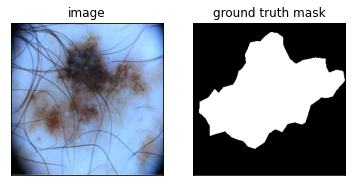

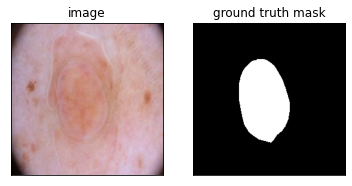

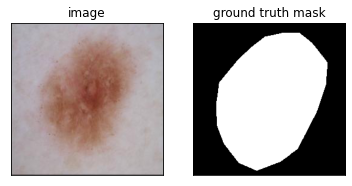

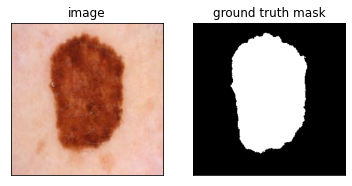

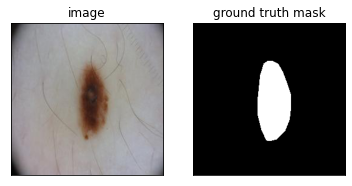

In [11]:
# Check images and masks are loaded properly
images, masks = next(train_generator)

for i, m in list(zip(images, masks))[:5]:
    _, axarr = plt.subplots(1, 2)

    plot_args = {
        'title': ['image', 'ground truth mask'],
        'args': [
            {'X': denormalize(i)},
            {'X': m[:, :, 0], 'cmap': 'gray'},
        ]
    }

    for ax, t, a in zip(axarr, plot_args['title'], plot_args['args']):
        ax.set_title(t)
        fig = ax.imshow(**a)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [12]:
class ImageCallback(keras.callbacks.Callback):
    def __init__(self, model):
        self.model = model

    def on_epoch_end(self, epoch, logs=None):
        mask = self.model.predict(images)[0]
        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1

        plot_args = {
            'title': ['image', 'predicted mask', 'ground truth mask'],
            'args': [
                {'X': denormalize(images[0])},
                {'X': mask[:, :, 0], 'cmap': 'gray'},
                {'X': masks[0, :, :, 0], 'cmap': 'gray'}
            ]
        }
        _, axarr = plt.subplots(1, 3)

        for ax, t, a in zip(axarr, plot_args['title'], plot_args['args']):
            ax.set_title(t)
            fig = ax.imshow(**a)
            fig.axes.get_xaxis().set_visible(False)
            fig.axes.get_yaxis().set_visible(False)
        plt.show()

In [13]:
TRAIN_COUNT = 160
VALIDATION_COUNT = 40
TUNE_EPOCHS = 50

In [14]:
def get_callbacks(idx):
    CHECKPOINT_PATH = f'onedrive6/segmentation_isic2018/unet/checkpoints/{idx}'
    last_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'{CHECKPOINT_PATH}/last',
        verbose=1
    )
    best_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'{CHECKPOINT_PATH}/best',
        save_best_only=True,
        monitor='val_mean_iou',
        mode='max',
        verbose=1
    )

    image_callback = ImageCallback(model)

    LOG_DIR = f'onedrive6/segmentation_isic2018/unet/logs/{idx}'
    board_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)

    stop_callback = tf.keras.callbacks.EarlyStopping(monitor='mean_iou', patience=10)

    return last_checkpoint, best_checkpoint, board_callback, stop_callback

In [15]:
HYPERPARAMETERS = {
    'optimizer': [tf.keras.optimizers.Adam, tf.keras.optimizers.Adagrad, tf.keras.optimizers.SGD],
    'learning_rate': [1e-2, 1e-3, 1e-4],
    'dropout_rate': [i/10 for i in range(3, 6)]
}

## Save best weights for each combination of hyperparameters

In [ ]:
for i, hp in enumerate(product(*HYPERPARAMETERS.values())):
    print('Evaluate hyperparameters values:')
    for p, v in zip((k for k in HYPERPARAMETERS), hp):
        print(f'{p}: {v}')

    # model = tf.keras.models.load_model(
    #     f'onedrive6/segmentation_isic2018/unet/checkpoints/{i}/last',
    #     custom_objects={'MeanIOU': MeanIOU}
    # )
    model = get_model(*hp)
    history = model.fit(train_data,
                        batch_size=BATCH_SIZE,
                        epochs=TUNE_EPOCHS,
                        verbose=1,
                        validation_data=validation_data,
                        shuffle=False,
                        steps_per_epoch=ceil(TRAIN_COUNT//BATCH_SIZE),
                        validation_steps=ceil(VALIDATION_COUNT//BATCH_SIZE),
                        callbacks=get_callbacks(i)
                        )

    with open(f'onedrive6/segmentation_isic2018/unet/logs/{i}/history.txt', 'w') as f:
        print(history, file=f)

Evaluate hyperparameters values:
optimizer: <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>
learning_rate: 0.01
dropout_rate: 0.3
Epoch 9/50
10/10 [==============================] - 178s 17s/step - loss: 0.6272 - mean_iou: 0.0000e+00 - val_loss: 0.6000 - val_mean_iou: 0.0000e+00

Epoch 00009: saving model to onedrive6/segmentation_isic2018/unet/checkpoints/0/last
INFO:tensorflow:Assets written to: onedrive6/segmentation_isic2018/unet/checkpoints/0/last/assets

Epoch 00009: val_mean_iou improved from -inf to 0.00000, saving model to onedrive6/segmentation_isic2018/unet/checkpoints/0/best
INFO:tensorflow:Assets written to: onedrive6/segmentation_isic2018/unet/checkpoints/0/best/assets
Epoch 10/50
10/10 [==============================] - 176s 18s/step - loss: 0.6257 - mean_iou: 0.0000e+00 - val_loss: 0.5926 - val_mean_iou: 0.0000e+00

Epoch 00010: saving model to onedrive6/segmentation_isic2018/unet/checkpoints/0/last
INFO:tensorflow:Assets written to: onedrive6/segmentation_isic

In [ ]:
!ls onedrive6/segmentation_isic2018

In [ ]:
%load_ext tensorboard
%tensorboard --logdir onedrive6/segmentation_isic2018/unet/1

In [ ]:
# best_iou, best_epoch, best_idx = 0.0, 0, 0
# best_hyperparameters = ()

# for hp in product(*HYPERPARAMETERS.values()):
#     print('Evaluate hyperparameters values:')
#     for p, v in zip((k for k in HYPERPARAMETERS), hp):
#       print(f'{p}: {v}')

#     model = get_model(*hp)
#     iou, epoch, idx = tune(model, train_data, validation_data)

#     if iou > best_iou:
#         best_hyperparameters, best_idx = hp, idx
#         best_iou, best_epoch = iou, epoch
#     break

# print('Best hyperparameters are:')
# for hp, v in zip((k for k in HYPERPARAMETERS), best_hyperparameters):
#     print(f'{hp}: {v}')
# print('Hyperparameters index is {idx}')    
# print(f'Best validation mean IoU: {best_iou}')
# print(f'achieved on epoch: {best_epoch}')